## Customer churn prediction
### Feed-forward Neural Networks

In [57]:
import pandas as pd
import numpy as np
import warnings
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, recall_score,precision_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/sheidamajidi/Desktop/Winter2024/Winter2024-2/MGSC673/Assignments/Assignment2/telecom_churn.csv')
data

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


### Exploratory Data Analysis

In [3]:
data.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


##### Missing values?

In [7]:
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64


##### What percentage of 1 and 0?

In [8]:
def plot_category_percentages_bar(df, column):
    counts = df[column].value_counts(normalize=True) * 100
    labels = [str(int(index)) for index in counts.index]
    values = counts.values
    fig = go.Figure(data=[go.Bar(x=labels, y=values, text=[f'{v:.2f}%' for v in values], textposition='auto')])
    fig.update_layout(title_text=f'Percentage of Categories in {column}', xaxis_title='Category', yaxis_title='Percentage', title_x=0.5)
    fig.show()

columns_to_plot = ['DataPlan', 'Churn', 'ContractRenewal']
for column in columns_to_plot:
    plot_category_percentages_bar(data, column)


##### Churn vs Count of variables

In [10]:
# Plot for AccountWeeks
data['AccountWeeks_bin'] = pd.cut(data['AccountWeeks'], bins=range(0, data['AccountWeeks'].max() + 26, 26), right=False)
account_weeks_churn = data.groupby(['AccountWeeks_bin', 'Churn']).size().unstack(fill_value=0)
fig = go.Figure()
fig.add_trace(go.Bar(x=account_weeks_churn.index.astype(str), 
                     y=account_weeks_churn[0], 
                     name='Churn 0', marker_color='grey'))
fig.add_trace(go.Bar(x=account_weeks_churn.index.astype(str), 
                     y=account_weeks_churn[1], 
                     name='Churn 1', marker_color='green'))
fig.update_layout(barmode='group', title='Churn by Account Weeks', title_x=0.5,
                   xaxis_title='Account Weeks Bin', yaxis_title='Count')
fig.show()

In [11]:
# Plot for DataUsage
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
data['DataUsage_bin'] = pd.cut(data['DataUsage'], bins=bins, right=False)
data_usage_churn = data.groupby(['DataUsage_bin', 'Churn']).size().unstack(fill_value=0)
fig = go.Figure()
fig.add_trace(go.Bar(x=data_usage_churn.index.astype(str), 
                     y=data_usage_churn[0], name='Churn 0', 
                     marker_color='grey'))
fig.add_trace(go.Bar(x=data_usage_churn.index.astype(str), 
                     y=data_usage_churn[1], name='Churn 1', 
                     marker_color='green'))
fig.update_layout(barmode='group', title='Churn by Data Usage', title_x=0.5,
                   xaxis_title='Data Usage Bin (GB)', yaxis_title='Count')
fig.show()


In [12]:
# Plot for CustServCalls
custserv_calls_churn = data.groupby(['CustServCalls', 'Churn']).size().unstack(fill_value=0)
fig = go.Figure()
fig.add_trace(go.Bar(x=custserv_calls_churn.index.astype(str), 
                     y=custserv_calls_churn[0], name='Churn 0', 
                     marker_color='grey'))
fig.add_trace(go.Bar(x=custserv_calls_churn.index.astype(str), 
                     y=custserv_calls_churn[1], name='Churn 1', 
                     marker_color='green'))
fig.update_layout(barmode='group', title='Churn by Customer Service Calls',title_x=0.5,
                   xaxis_title='Customer Service Calls', yaxis_title='Count')
fig.show()


In [13]:
# Plot for MonthlyCharge
data['MonthlyCharge_bin'] = pd.qcut(data['MonthlyCharge'], q=10)
monthly_charge_churn = data.groupby(['MonthlyCharge_bin', 'Churn']).size().unstack(fill_value=0)
fig = go.Figure()
fig.add_trace(go.Bar(x=monthly_charge_churn.index.astype(str), 
                     y=monthly_charge_churn[0], name='Churn 0', 
                     marker_color='grey'))
fig.add_trace(go.Bar(x=monthly_charge_churn.index.astype(str), 
                     y=monthly_charge_churn[1], name='Churn 1', 
                     marker_color='green'))
fig.update_layout(barmode='group', title='Churn by Monthly Charge', title_x=0.5,
                  xaxis_title='Monthly Charge Bin ($)', yaxis_title='Count')
fig.show()


In [14]:
# Plot for OverageFee
data['OverageFee_bin'] = pd.qcut(data['OverageFee'], q=10)
overage_fee_churn = data.groupby(['OverageFee_bin', 'Churn']).size().unstack(fill_value=0)
fig = go.Figure()
fig.add_trace(go.Bar(x=overage_fee_churn.index.astype(str), 
                     y=overage_fee_churn[0], name='Churn 0', 
                     marker_color='grey'))
fig.add_trace(go.Bar(x=overage_fee_churn.index.astype(str), 
                     y=overage_fee_churn[1], name='Churn 1', 
                     marker_color='green'))
fig.update_layout(barmode='group', title='Churn by Overage Fee', title_x=0.5,
                  xaxis_title='Overage Fee Bin ($)', yaxis_title='Count')
fig.show()


#### Split dataset into training and testing set, with Target as "Churn"

In [15]:
data.columns

Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins', 'AccountWeeks_bin', 'DataUsage_bin', 'MonthlyCharge_bin',
       'OverageFee_bin'],
      dtype='object')

In [26]:
columns = ['AccountWeeks', 
        'ContractRenewal', 
        'DataPlan', 
        'DataUsage',
        'CustServCalls', 
        'DayMins', 
        'DayCalls', 
        'MonthlyCharge', 
        'OverageFee',
        'RoamMins'
    ]
target = ['Churn']

x = data[columns]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_fit , x_val, y_fit, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

In [27]:
# scale the data
scaler = StandardScaler()

x_fit_scaled = scaler.fit_transform(x_fit)

x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

print('Scaled train data:', x_fit_scaled.shape)
print('Scaled validation data:', x_val_scaled.shape)
print('Scaled test data:', x_test_scaled.shape)


Scaled train data: (2132, 10)
Scaled validation data: (534, 10)
Scaled test data: (667, 10)


### This will be used for printing metrics

In [43]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

##### Model 1

In [44]:
K.clear_session()

nshape = x_fit_scaled.shape[1]

#  model building
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(nshape,)),
    BatchNormalization(),  
    Dropout(0.3),  

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid') 
])


model1.compile(optimizer=Adam(learning_rate=0.001),  # adjust learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), F1Score()])


history1 = model1.fit(x_fit_scaled, y_fit, epochs=100, batch_size=32, validation_data=(x_val_scaled, y_val))

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5405 - auc: 0.5787 - f1_score: 0.2285 - loss: 0.8064 - val_accuracy: 0.8371 - val_auc: 0.8167 - val_f1_score: 0.5029 - val_loss: 0.5972
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7678 - auc: 0.7698 - f1_score: 0.4520 - loss: 0.5291 - val_accuracy: 0.8745 - val_auc: 0.8525 - val_f1_score: 0.4553 - val_loss: 0.4649
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8148 - auc: 0.7510 - f1_score: 0.4149 - loss: 0.4500 - val_accuracy: 0.8876 - val_auc: 0.8732 - val_f1_score: 0.4828 - val_loss: 0.3559
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.8690 - auc: 0.8247 - f1_score: 0.5229 - loss: 0.3482 - val_accuracy: 0.8839 - val_auc: 0.8861 - val_f1_score: 0.5231 - val_loss: 0.3015
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8735 - auc: 0.8361 - f1_score: 0.4862 - loss: 0.3178 - val_accuracy: 0.9026 - val_auc: 0.8713 - val_f1_score: 0.5806 - val_

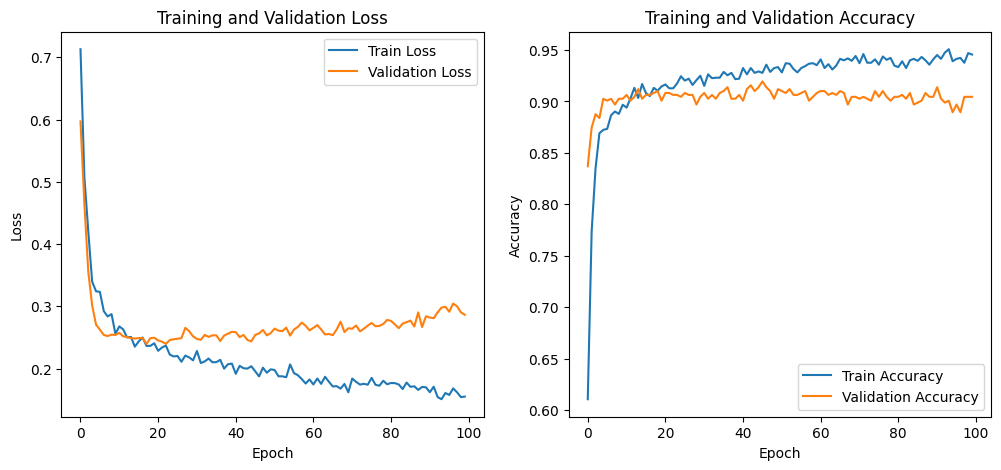

In [45]:
def plot_val_train_loss(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_val_train_loss(history1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


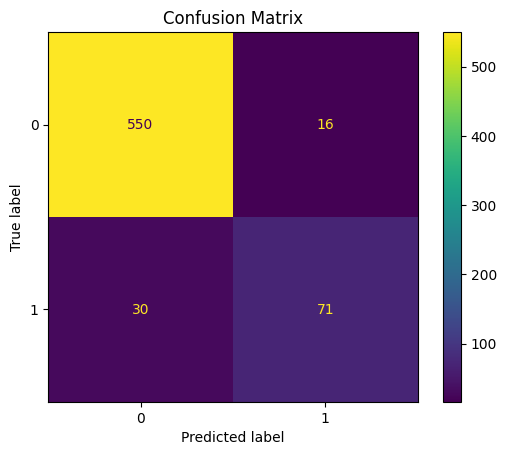

Custom F1 Score: 0.7553191


In [47]:
# Prediction
predictions = model1.predict(x_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculating F1 Score
f1_score_metric = F1Score()
f1_score_metric.update_state(y_test, predictions)
f1_score = f1_score_metric.result().numpy()
print("Custom F1 Score:", f1_score)


##### Model 2

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 0.6653 - val_accuracy: 0.8558 - val_loss: 0.5064
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.8496 - loss: 0.5047 - val_accuracy: 0.8539 - val_loss: 0.4225
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.8570 - loss: 0.4208 - val_accuracy: 0.8539 - val_loss: 0.3752
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.8511 - loss: 0.3843 - val_accuracy: 0.8670 - val_loss: 0.3477
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.8606 - loss: 0.3442 - val_accuracy: 0.8558 - val_loss: 0.3333
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.8667 - loss: 0.3126 - val_accuracy: 0.8633 - val_loss: 0.3248
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.8752 - loss: 0.2983 - val_accuracy: 0.8745 - val_loss: 0.3159
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.8892 - loss: 0.2974 - val_accuracy: 0.87

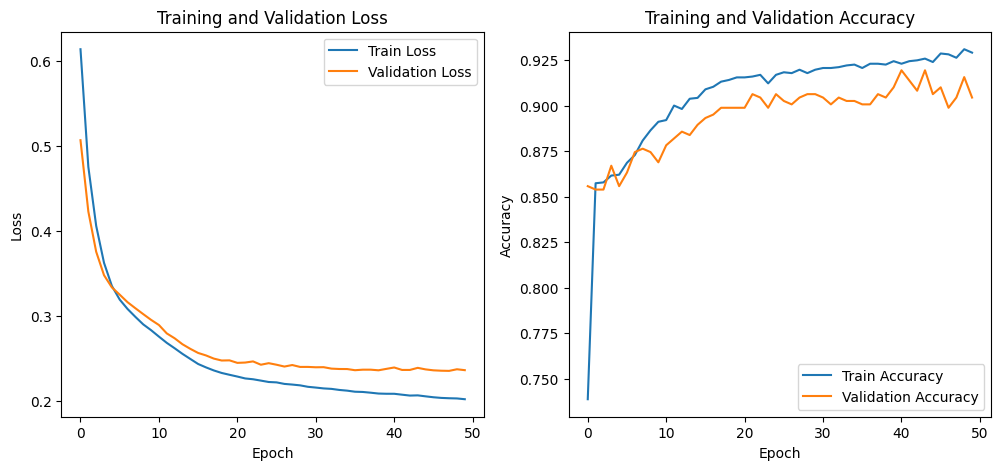

In [38]:
K.clear_session()
model2 = Sequential([
    Dense(10, activation='relu', input_shape=(nshape,)),
    Dense(15, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history2 = model2.fit(x_fit_scaled, y_fit, epochs=50, validation_data=(x_val_scaled, y_val))
model2.evaluate(x_test_scaled, y_test)

plot_val_train_loss(history2)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step


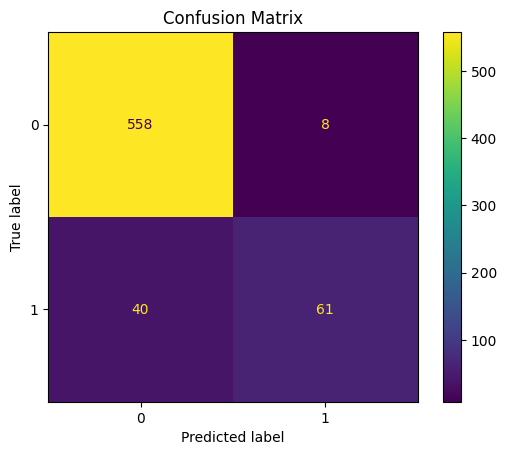

Custom F1 Score: 0.717647


In [48]:
# Prediction
predictions = model2.predict(x_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculating F1 Score
f1_score_metric = F1Score()
f1_score_metric.update_state(y_test, predictions)
f1_score = f1_score_metric.result().numpy()
print("Custom F1 Score:", f1_score)


##### Model 3

In [50]:
# model 3 with early stopping

nshape = x_fit_scaled.shape[1]

K.clear_session()
model3 = Sequential([
    Dense(128, activation='relu', input_shape=(nshape,)),
    Dropout(0.2),
    Dense(128, activation='relu'), 
    Dense(1024, activation='sigmoid'), 
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dense(1, activation='sigmoid')
])

early_stopping3 = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
model3.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), F1Score()])
history3 = model3.fit(x_fit_scaled, y_fit, epochs=500, batch_size=32, validation_data=(x_val_scaled, y_val), callbacks=[early_stopping3])


Epoch 1/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8681 - auc: 0.5398 - f1_score: 0.0000e+00 - loss: 0.4366 - val_accuracy: 0.8577 - val_auc: 0.8498 - val_f1_score: 0.0500 - val_loss: 0.3087
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8759 - auc: 0.8482 - f1_score: 0.3393 - loss: 0.2935 - val_accuracy: 0.8652 - val_auc: 0.8681 - val_f1_score: 0.5385 - val_loss: 0.2901
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8922 - auc: 0.8968 - f1_score: 0.5220 - loss: 0.2654 - val_accuracy: 0.8839 - val_auc: 0.8947 - val_f1_score: 0.4151 - val_loss: 0.2759
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - auc: 0.8819 - f1_score: 0.4317 - loss: 0.2781 - val_accuracy: 0.8895 - val_auc: 0.8861 - val_f1_score: 0.5755 - val_loss: 0.2717
Epoch 5/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - auc: 0.8872 - f1_score: 0.5397 - loss: 0.2750 - val_accuracy: 0.8951 - val_auc: 0.8907 - val_f1_score: 0.5000 - val_loss

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


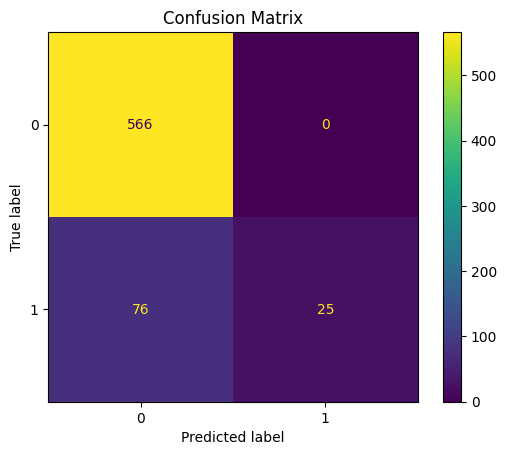

Custom F1 Score: 0.39682537


In [51]:
# Prediction
predictions = model3.predict(x_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculating F1 Score
f1_score_metric = F1Score()
f1_score_metric.update_state(y_test, predictions)
f1_score = f1_score_metric.result().numpy()
print("Custom F1 Score:", f1_score)


#### Model 4

In [52]:
# model 4 with Early Stopping
K.clear_session()
model4 = Sequential([
    Dense(128, activation='relu', input_shape=(nshape,)),
    Dense(128, activation='relu'), 
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

early_stopping4 = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)
model4.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), F1Score()])
history4 = model4.fit(x_fit_scaled, y_fit, epochs=500, batch_size=32, validation_data=(x_val_scaled, y_val), callbacks=[early_stopping4])


Epoch 1/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8533 - auc: 0.6539 - f1_score: 0.1282 - loss: 0.4229 - val_accuracy: 0.8764 - val_auc: 0.8685 - val_f1_score: 0.5479 - val_loss: 0.2984
Epoch 2/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.9050 - auc: 0.8895 - f1_score: 0.6120 - loss: 0.2559 - val_accuracy: 0.8914 - val_auc: 0.8924 - val_f1_score: 0.6081 - val_loss: 0.2651
Epoch 3/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.9137 - auc: 0.8975 - f1_score: 0.6300 - loss: 0.2391 - val_accuracy: 0.8914 - val_auc: 0.8829 - val_f1_score: 0.5397 - val_loss: 0.2647
Epoch 4/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.9174 - auc: 0.9060 - f1_score: 0.6750 - loss: 0.2255 - val_accuracy: 0.8951 - val_auc: 0.8965 - val_f1_score: 0.5758 - val_loss: 0.2502
Epoch 5/500
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.9332 - auc: 0.9108 - f1_score: 0.7417 - loss: 0.2051 - val_accuracy: 0.8914 - val_auc: 0.9019 - val_f1_score: 0.5167 - val_

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


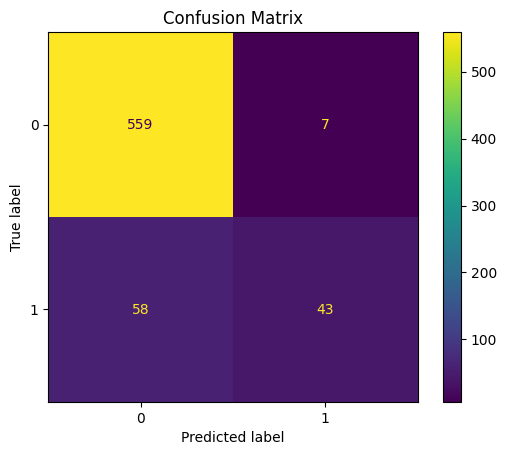

Custom F1 Score: 0.5695364


In [53]:
# Prediction
predictions = model4.predict(x_test_scaled)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Calculating F1 Score
f1_score_metric = F1Score()
f1_score_metric.update_state(y_test, predictions)
f1_score = f1_score_metric.result().numpy()
print("Custom F1 Score:", f1_score)


### Comparing performance of models 

In [55]:
# performance data
results = []
models = [model1, model2, model3, model4]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
for model, name in zip(models, model_names):
    predictions = model.predict(x_test_scaled)
    predicted_classes = (predictions > 0.5).astype(int)
    auc = roc_auc_score(y_test, predictions)
    f1 = f1_score(y_test, predicted_classes)
    results.append({'Model': name, 'AUC': auc, 'F1 Score': f1})


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


In [62]:
# plotting the performance
df_results = pd.DataFrame(results)
fig = px.bar(df_results, x='Model', y='AUC', title='AUC comparison across models')
fig.show()

fig2 = px.bar(df_results, x='Model', y='F1 Score', title='F1 Score comparison across models')
fig2.show()

In [63]:
results = []
models = [model1, model2, model3, model4] 
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

for model, name in zip(models, model_names):
    predictions = model.predict(x_test_scaled)
    predicted_classes = (predictions > 0.5).astype(int)
    auc = roc_auc_score(y_test, predictions)
    f1 = f1_score(y_test, predicted_classes)
    accuracy = accuracy_score(y_test, predicted_classes)
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'AUC': auc,
        'F1 Score': f1
    })

for result in results:
    print(f"Metrics for {result['Model']}:")
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  AUC: {result['AUC']:.4f}")
    print(f"  F1 Score: {result['F1 Score']:.4f}\n")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
Metrics for Model 1:
  Accuracy: 0.9310
  AUC: 0.9155
  F1 Score: 0.7553

Metrics for Model 2:
  Accuracy: 0.9280
  AUC: 0.9250
  F1 Score: 0.7176

Metrics for Model 3:
  Accuracy: 0.8861
  AUC: 0.9193
  F1 Score: 0.3968

Metrics for Model 4:
  Accuracy: 0.9025
  AUC: 0.9080
  F1 Score: 0.5695

